### van der Ven filters

Van der Ven 1995 defined a series of filters in spectral space. The original paper was concerned with filters with non-uniform filter scale. However, we noticed that these filters had the property that higher order ones could potentially be used for estimating steeper spectra.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
#from scipy import fft
import jax.numpy.fft as fft

These filter functions are defined in terms of their fourier coefficients.

$$
\hat{G} (k) = exp (- \frac{\alpha}{2 m} k^{2m} )
$$

For m =1, we get a gaussian function where the $\sigma = 1 / \sqrt{\alpha}$. 

The form we actually use is : 

$$
\hat{G} (k) = exp (-\frac{1}{2m} k^{2m}  (2\pi \sigma)^{2m})
$$
as this gives the exact fourier transform of gaussian for m=1.

In [2]:
# Function
#def Ghat(k, m, alpha=1):
#     return jnp.exp( -alpha**m  / (2*m) * (k**(2*m)) )

def Ghat(k, m, sigma=1.):
     return jnp.exp( -1 / (2*m) * (k**(2*m)) * 
                    (2*np.pi*sigma)**(2*m) )
    
# This form preserves the exact structure of Gaussian for m=1.

In [3]:
N = 511 # best to keep this odd, so that weight is centered at origin with even number of points on both side. 
L = 2000 

dx = L/N

k = fft.fftfreq(N , d=dx)

In [4]:
#sigma = 1/ 200
lfilter = 50
alpha = lfilter / np.sqrt(12) 

Ghat_m1 = Ghat(k,1, alpha)
Ghat_m2 = Ghat(k,2, alpha)
Ghat_m3 = Ghat(k,3, alpha)
Ghat_m4 = Ghat(k,4, alpha)

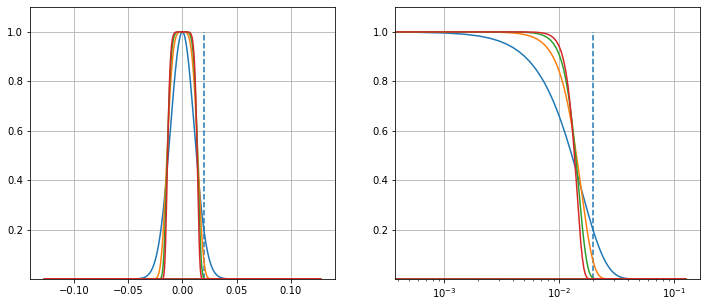

In [5]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(k, Ghat_m1)
plt.plot(k, Ghat_m2)
plt.plot(k, Ghat_m3)
plt.plot(k, Ghat_m4)

plt.vlines(1/lfilter, 0, 1, linestyles='--')

#plt.xscale('log')
#plt.yscale('log')

plt.ylim([1e-7, 1.1])
plt.grid()

plt.subplot(122)
plt.plot(k, Ghat_m1)
plt.plot(k, Ghat_m2)
plt.plot(k, Ghat_m3)
plt.plot(k, Ghat_m4)

plt.vlines(1/lfilter, 0, 1, linestyles='--')

plt.xscale('log')
#plt.yscale('log')

plt.ylim([1e-7, 1.1])
plt.grid()

In [6]:
G_m1 = jnp.roll( fft.ifft(Ghat_m1), int((N - 1)/2) )
G_m2 = jnp.roll( fft.ifft(Ghat_m2), int((N - 1)/2) )
G_m3 = jnp.roll( fft.ifft(Ghat_m3), int((N - 1)/2) )
G_m4 = jnp.roll( fft.ifft(Ghat_m4), int((N - 1)/2) )

In [7]:
x = np.arange(0,N) * dx

In [8]:
def gaussian_kernel(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    p = np.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    x = np.arange(-radius, radius + 1)
    
    # E^(p(x))
    phi_x = np.exp(p(x), dtype=np.double)
    
    # normalization
    phi_x /= phi_x.sum()
        
    return phi_x

In [9]:
sigmafilter = lfilter / np.sqrt(12) 
nfilter_gauss = sigmafilter/dx
f_gauss_test = gaussian_kernel(nfilter_gauss, (N - 1)/2)

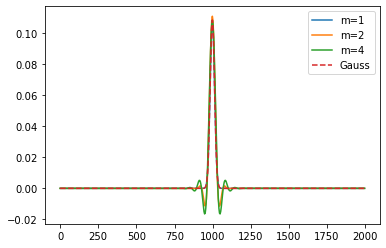

In [10]:
plt.plot(x, G_m1.real, label='m=1')
plt.plot(x, G_m2.real, label='m=2')
plt.plot(x, G_m3.real, label='m=4')
#plt.plot(x, G_m4)
plt.plot(x  , f_gauss_test, '--', label='Gauss')

plt.legend()
#plt.xlim([300, 700])

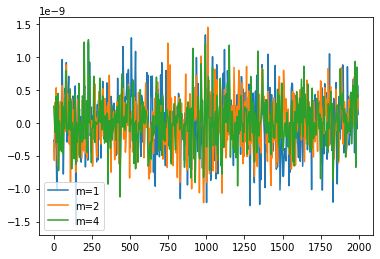

In [11]:
plt.plot(x, G_m1.imag, label='m=1')
plt.plot(x, G_m2.imag, label='m=2')
plt.plot(x, G_m3.imag, label='m=4')
#plt.plot(x, G_m4)
#plt.plot(x  , f_gauss_test, '--', label='Gauss')

plt.legend()
#plt.xlim([300, 700])

So we were able to create the real space versions of the VDV filters! 

Somethings to note: 
- Our sort of adhoc way, learnt from the formula for gaussian, of defining the filter scale seems to have worked quite well.
- The length of the domain does not change the size of the filter. This is obvious. 
- The number of wavenumbers chosen is equivalent to the resolution of the filter, as that is eqivalent to the number of grid points in the domain. 


- We probably don't want the above to be true when we design a filter as we would like to be as close to the real filter as possible (use max k), but be able obtain its values at the few needed grid points. 
- Also we should do all our work in number of grid points and grind point units to stay consistent with the other filters that are there in scipy.
- Also we want the grid side - dx - to be the same between filter and signal to be filtered. 

So we can have two options:
- Where k is kept high, but filter is evaluated only at few x. 
- where k changes based on filter scale. 


#### Put above code into a filter kernel

We use the second option from above to create our filters, as it is more straightforward.  (the first option can be tried out later). 

In [12]:
def G_m(sigma, radius, m=1.):
    """
    Computes a 1D Van der ven kernel
    
    Everything is in grid point units 
    """
    
    x = np.arange(-radius, radius+1)
    N = len(x)
    k = fft.fftfreq(N)
    
    Ghat_m = Ghat(k, m, sigma)
    
    G_m = jnp.roll( fft.ifft(Ghat_m), int ((N-1)/2)) 
    
    return G_m , x 

In [13]:
sigma_n = 8
truncate = 10.0 
lw = int(truncate * float(sigma_n) + 0.5)

In [14]:
Gtest_m1, xn = G_m(sigma_n, lw, m=1)
Gtest_m2, _ = G_m(sigma_n, lw, m=2)
Gtest_m3, _ = G_m(sigma_n, lw, m=3)

In [15]:
f_gauss_test = gaussian_kernel(sigma_n, lw)

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


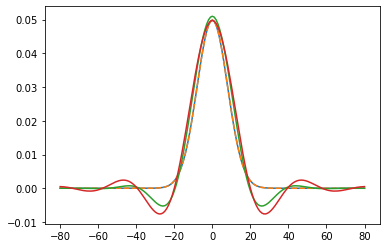

In [16]:
plt.plot(xn, Gtest_m1)
plt.plot(xn, f_gauss_test, '--')
plt.plot(xn, Gtest_m2)
plt.plot(xn, Gtest_m3)

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


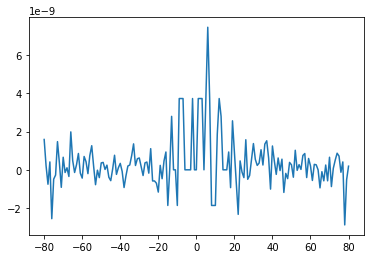

In [17]:
plt.plot(xn, Gtest_m1 - f_gauss_test)

A few points about this kernel: 
- The truncate width needs to be wider, to accomodate the negative lobes.
- The error relative to the kernel defined directly in real space seems be 6-7 order of ma

### Order of VDV filters 

Why did we go on this tour of VDV filters? The reason for this that we have the ability to set the order of the filter, as the parameter m. 

For any filter $G(x)$ with the fourier transform $\hat{G}(k)$, the nth moment is defined as: 
$$
M_n = \int x^n G(x) dx = \hat{G}^{(n)} (k) |_{k=0}. 
$$
The 0th moment is just 1 for normalized kernels. If the first p moments (1, 2..p) are zero, then the filter is said to be order p. Or for pth order filter, the p+1 moment is nonzero. 
Gaussian and top-hat filters are 1st order.

The order is important because the steepest power law slope detectable by a filter is p+2 (Sadek and Aluie 2018). 

Turns out that we can use the m parameter in VDV filters to set the order. 

We can show this by computing the gradients. This is the reason we imported jax, which allows us to compute gradients of functions. 

In [18]:
Ghat_n1 = jax.grad(Ghat)
Ghat_n2 = jax.grad(Ghat_n1)
Ghat_n3 = jax.grad(Ghat_n2)
Ghat_n4 = jax.grad(Ghat_n3)

In [19]:
# 1st moment
Ghat_n1(0.,1), Ghat_n1(0.,2),  Ghat_n1(0.,3) 

(DeviceArray(-0., dtype=float32, weak_type=True),
 DeviceArray(-0., dtype=float32, weak_type=True),
 DeviceArray(-0., dtype=float32, weak_type=True))

In [20]:
# 2nd moment (notice this is non-zero for m=1, which is Gaussian)
Ghat_n2(0.,1), Ghat_n2(0.,2),  Ghat_n2(0.,3)  

(DeviceArray(-39.478416, dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

In [21]:
# 3rd moment (this is zero for all, 
# as we have symmetric kernels - where all odd moments are 0)
Ghat_n3(0.,1), Ghat_n3(0.,2),  Ghat_n3(0.,3)  

(DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

In [22]:
# 4th moment
Ghat_n4(0.,1), Ghat_n4(0.,2),  Ghat_n4(0.,3)  

(DeviceArray(4675.636, dtype=float32, weak_type=True),
 DeviceArray(-9351.272, dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

The 4th moment is non-zero for m=2 VDV kernel. This mean VDVm2 is a 3rd order kernel. 3rd order kernels are capable of detecting spectral slopes as steep as -5.